# Benchmarking with IBM's circuit on different fidelity losses

Q-Alchemy's state preparation module allows the users to set the fidelity loss between the final state and the target state. In this section, we will illustrate how the fielity loss affects the quality of the final solution as well as the depth of the state preparation circuit.

In [1]:
import os
import sys

import numpy as np
from linear_solvers import NumPyLinearSolver, HHL
from qiskit.circuit import QuantumCircuit, QuantumRegister
from qiskit.compiler import transpile
from qiskit.quantum_info import Statevector

os.environ["Q_ALCHEMY_API_KEY"] = "<your key here>"
sys.path.append('..')
from q_alchemy.initialize import q_alchemy_as_qasm
from qiskit.opflow import (
    Z,
    I,
    StateFn,
    TensoredOp,
)

In [2]:
def calculate_norm(qc: QuantumCircuit, nb: int, nl: int, na:int) -> float:
        """Calculates the value of the euclidean norm of the solution.

        Args:
            qc: The quantum circuit preparing the solution x to the system.

        Returns:
            The value of the euclidean norm of the solution.
        """

        # Create the Operators Zero and One
        zero_op = (I + Z) / 2
        one_op = (I - Z) / 2

        # Norm observable
        observable = one_op ^ TensoredOp((nl + na) * [zero_op]) ^ (I ^ nb)
        norm_2 = (~StateFn(observable) @ StateFn(qc)).eval()
        

        return np.real(np.sqrt(norm_2))

In [3]:
def get_solution_vector(solution, length):
    raw_solution_vector = Statevector(solution.state)
    numq = solution.state.num_qubits
    n = 2**(numq-1)
    print(raw_solution_vector)
    solution_vector = Statevector(solution.state).data[n:n+length].real
    print(solution_vector)
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)

In [4]:
import re

def ibm_decompose(qc):
    state_inst = qc.data[0]
    qubit = str(state_inst[1][0])
    name = re.findall(r"'([^']*)'", qubit)[0]
    qr = QuantumRegister(3, name)
    qc_raw = QuantumCircuit(qr)
    qc_raw.data = [state_inst]
    qc = transpile(qc_raw, basis_gates=["id", "rx", "ry", "rz", "cx"])
    return qc
    

In [5]:
def q_alchemy_prep(b, fid_loss):
    sp_qasm = q_alchemy_as_qasm(b, max_fidelity_loss=fid_loss, basis_gates=["id", "rx", "ry", "rz", "cx"])
    qc = QuantumCircuit.from_qasm_str(sp_qasm)
    return qc

In [6]:
def circuit_depth_generator(b, fid_loss):
    qc = q_alchemy_prep(b, fid_loss)
    depth = qc.depth()
    return depth

## Quantifying the quality of the solution

We are going to look at two different measures to quantify the difference between two vectors. First, we will focus on the angle between two vectors which will be given by angle_diff in the function below. Secondly, we will look at the norm of the difference of two vectors. This will be given as norm_diff. If two vectors are similar we will obtain angle_diff close to 0, and norm_diff clost to 0. We will implement these two measures on the solution obtained by HHL algorithm and the classical solution to quantify the difference.

In [7]:
def answer_comparison(x1, x2):
    dot_product = np.dot(x1, x2)
    norm1 = np.linalg.norm(x1)
    norm2 = np.linalg.norm(x2)
    
    cosine_similarity = dot_product/(norm1*norm2)
    angle_diff = np.arccos(cosine_similarity)
    
    diff = (x1-x2)
    norm_diff = np.linalg.norm(diff)/np.linalg.norm(x2)
    return angle_diff, norm_diff

## Comparing the circuit depth
Define Matrices and solutions

In [8]:
b_path = 'hhl_data/trial_solution.npy'
data_path = 'hhl_data/hhl_qalchemy_results_0.01.csv'

b = np.loadtxt(b_path)


A = np.array([[1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [2.0, 3.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [3.0, 4.0, 4.0, 5.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 8.0, 9.0, 0.0, 10.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 11.0, 12.0]])
ibm = HHL().solve(A, b)
ibm.state.draw()


┌──────────────┐┌───────┐        ┌──────────┐
q8_0: ┤0             ├┤9      ├────────┤9         ├
      │              ││       │        │          │
q8_1: ┤1 circuit-159 ├┤10     ├────────┤10        ├
      │              ││       │        │          │
q8_2: ┤2             ├┤11     ├────────┤11        ├
      └──────────────┘│       │┌──────┐│          │
q9_0: ────────────────┤0      ├┤8     ├┤0         ├
                      │       ││      ││          │
q9_1: ────────────────┤1      ├┤7     ├┤1         ├
                      │       ││      ││          │
q9_2: ────────────────┤2      ├┤6     ├┤2         ├
                      │   QPE ││      ││   QPE_dg │
q9_3: ────────────────┤3      ├┤5     ├┤3         ├
                      │       ││      ││          │
q9_4: ────────────────┤4      ├┤4     ├┤4         ├
                      │       ││  1/x ││          │
q9_5: ────────────────┤5      ├┤3     ├┤5         ├
                      │       ││      ││          │
q9_6: ────────────────┤6      ├┤2     ├┤6         ├
                      │       ││      ││          │
q9_7: ────────────────┤7      ├┤1     ├┤7         ├
                      │       ││      ││          │
q9_8: ────────────────┤8      ├┤0     ├┤8         ├
                      └───────┘│      │└──────────┘
 q10: ─────────────────────────┤9     ├────────────
                               └──────┘

### IBM's state preparation circuit

C:\Users\CarstenBlank\Documents\qalchemy\q-alchemy-sdk-py\.venv\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


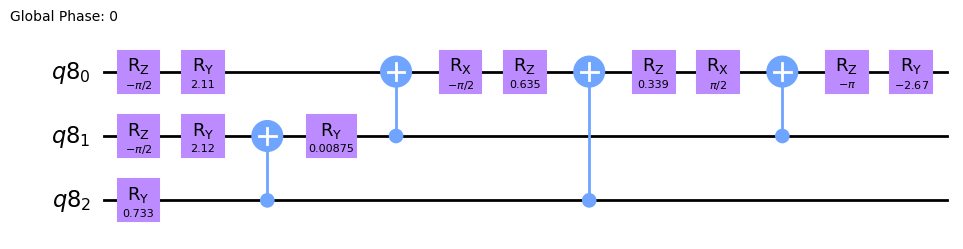

In [9]:
ibm_state = ibm_decompose(ibm.state)
ibm_state.draw('mpl')


### Q-alchemy's state preparation circuit

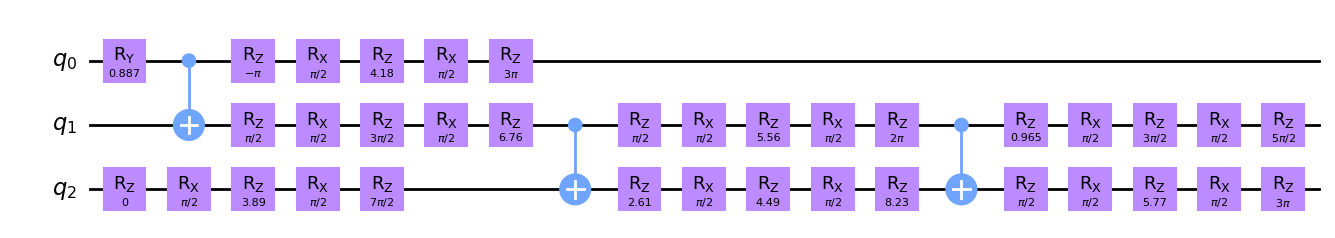

In [10]:
q_alchemy = q_alchemy_prep(b, 0.0)
q_alchemy.draw('mpl')

### Comparing circuit depth

In [11]:
ibm_depth = ibm_state.depth()
qal_depth = q_alchemy.depth()

print(f'IBM circuit depth: {ibm_depth}')
print(f'Q-Alchemy circuit depth: {qal_depth}')

IBM circuit depth: 13
Q-Alchemy circuit depth: 19


## Benchmarking

In hhl_experiment.py, we have run the HHL algorithm for a given $A$ and $\vec{b}$ with varying fidelity loss from 0 to 1 with the step size of 0.01 and stored the result in hhl_data folder. Here, we will load the data and compare the results with IBM's default method.

In [12]:
classical_solution = NumPyLinearSolver().solve(A, b)

In [13]:
import pandas as pd

df = pd.read_csv(data_path, index_col=0)
qal_norms = df['norms'].values
qal_fids = df['fid_loss'].values
ibm_norms = [ibm.euclidean_norm] * len(qal_norms)
classical_norms = [classical_solution.euclidean_norm]*len(qal_norms)

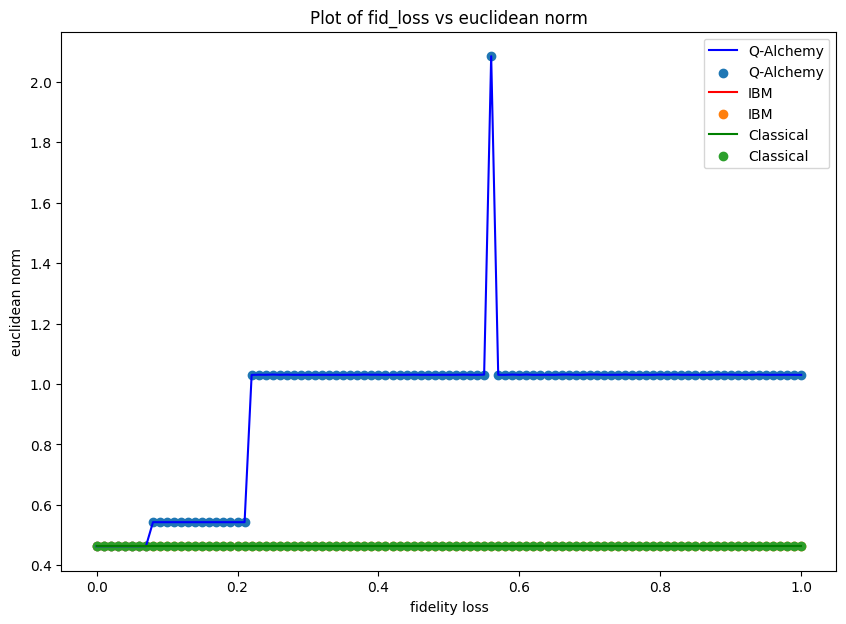

In [14]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, qal_norms, color='blue', label='Q-Alchemy')
plt.scatter(qal_fids, qal_norms, label='Q-Alchemy')

plt.plot(qal_fids, ibm_norms, color='red', label='IBM')
plt.scatter(qal_fids, ibm_norms, label='IBM')

plt.plot(qal_fids, classical_norms, color='green', label='Classical')
plt.scatter(qal_fids, classical_norms, label='Classical')

plt.xlabel('fidelity loss')
plt.ylabel('euclidean norm')
plt.title('Plot of fid_loss vs euclidean norm')
plt.legend()
plt.show()

In [15]:
qal_depths = [circuit_depth_generator(b, fid_loss) for fid_loss in qal_fids]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
fig: Figure = plt.figure(figsize =(10, 7))

ibm_depths = [ibm_depth]*len(qal_fids)

plt.plot(qal_fids, qal_depths, color='blue', label='Q-Alchemy')
plt.scatter(qal_fids, qal_depths, label='Q-Alchemy')

plt.plot(qal_fids, ibm_depths, color='red', label='IBM')
plt.scatter(qal_fids, ibm_depths, label='IBM')

plt.xlabel('fidelity loss')
plt.ylabel('circuit depth')
plt.title('Plot of fid_loss vs circuit depth')
plt.legend()
plt.show()

In [55]:
df = pd.read_csv(data_path, index_col=0)
len(df['solution'])

101

In [56]:
import ast
import numpy as np

qal_solution = []
for i in range(len(df['solution'])):
    str_array = df['solution'][i]
    cleaned_str = str_array.replace('array(', '').replace('(', '').replace(')', '').replace('\n', '')
    
    evaluated_list = ast.literal_eval(cleaned_str)

    numpy_array = np.array(evaluated_list)
    array = numpy_array.reshape(8)
    qal_solution.append(array)
    
print(len(qal_solution))


101


In [82]:
norm_ibm_diffs = []
angle_ibm_diffs = []

norm_classical_diffs = []
angle_classical_diffs = []

ibm_solution = default_sol = get_solution_vector(ibm, 8)


for i in range(len(qal_solution)):
    angle_ibm, norm_ibm = answer_comparison(qal_solution[i], ibm_solution)
    angle_classical, norm_classical = answer_comparison(qal_solution[i], classical_solution.state)
    
    norm_ibm_diffs.append(norm_ibm)
    angle_ibm_diffs.append(angle_ibm)
    
    norm_classical_diffs.append(norm_classical)
    angle_classical_diffs.append(angle_classical)
    

/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/wooseophwang/anaconda3/envs/new/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Statevector([ 2.18600800e-01-1.36086349e-15j,
              3.75735328e-01-1.38588147e-13j,
              7.94636206e-01-4.43396050e-13j, ...,
             -3.33450187e-17-1.11920443e-05j,
              3.03689319e-17+1.14166954e-05j,
              7.32188994e-18+5.76539853e-06j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
[ 0.08551378 -0.03352393  0.00357725  0.00401697  0.00026832  0.00299444
 -0.00253723  0.00272855]


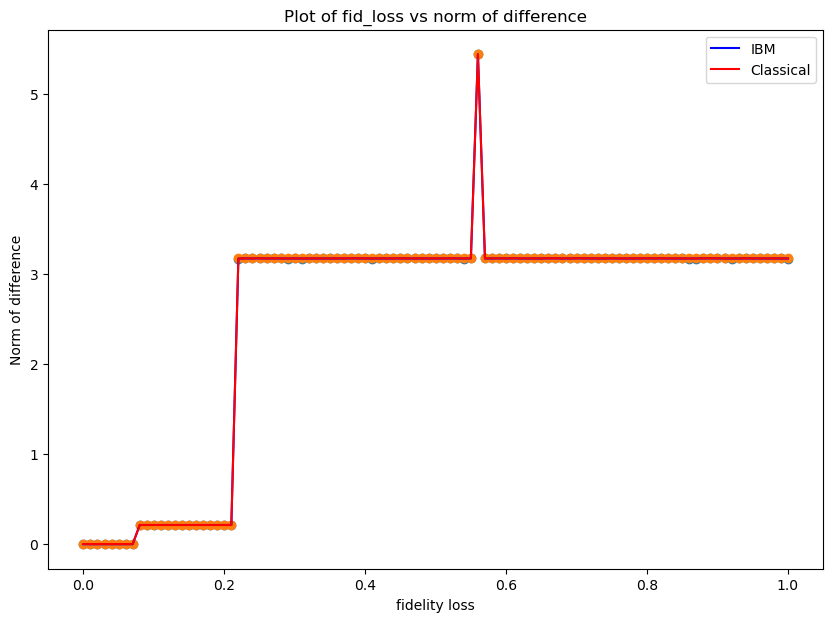

In [85]:
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, norm_ibm_diffs, color='blue', label='IBM')
plt.scatter(qal_fids, norm_ibm_diffs)

plt.plot(qal_fids, norm_classical_diffs, color='red', label='Classical')
plt.scatter(qal_fids, norm_classical_diffs)

plt.xlabel('fidelity loss')
plt.ylabel('Norm of difference')
plt.title('Plot of fid_loss vs norm of difference')
plt.legend()
plt.show()

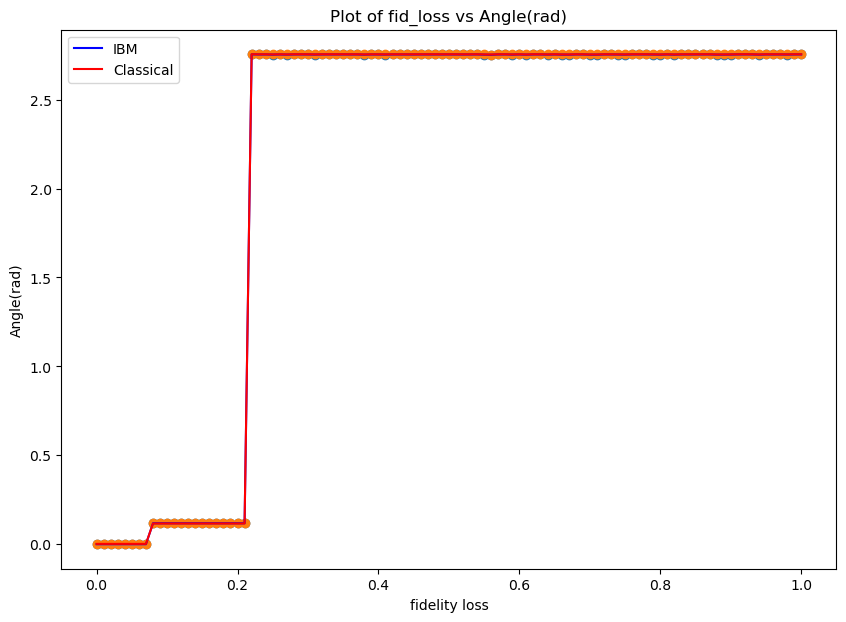

In [86]:
fig: Figure = plt.figure(figsize =(10, 7))

plt.plot(qal_fids, angle_ibm_diffs, color='blue', label='IBM')
plt.scatter(qal_fids, angle_ibm_diffs)

plt.plot(qal_fids, angle_classical_diffs, color='red', label='Classical')
plt.scatter(qal_fids, angle_classical_diffs)

plt.xlabel('fidelity loss')
plt.ylabel('Angle(rad)')
plt.title('Plot of fid_loss vs Angle(rad)')
plt.legend()
plt.show()

In [87]:
print(qal_solution[-1])
print(ibm_solution)

print(norm_ibm_diffs)

[-0.76632306  0.67212685 -0.06826459  0.12824411  0.02449324 -0.00999026
  0.02452421 -0.00547588]
[ 0.4299204  -0.16854153  0.01798463  0.02019533  0.001349    0.01505456
 -0.0127559   0.01371777]
[1.2834555268863081e-08, 1.2834555268863081e-08, 1.2834555268863081e-08, 1.2834555268863081e-08, 1.2834555268863081e-08, 1.2834555268863081e-08, 1.2834555268863081e-08, 1.2834555268863081e-08, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 0.21373705314218813, 3.172673545841907, 3.173775359243304, 3.173397230979023, 3.1747236042135034, 3.173321924000714, 3.174167435995456, 3.173322708518895, 3.173101911791121, 3.1733245414018554, 3.1730736322552486, 3.173360496658387, 3.173201462043996, 3.1733152691790387, 3.1731680357705034, 3.1733488939569354, 3.173386362252247, 3.174